In [1]:
import seaborn
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind/notebooks/scatac

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/notebooks/scatac


In [3]:
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [4]:
pwms = mb.datasets.cisbp_hs()



In [5]:
len(pwms)

7704

In [6]:
import random
reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [7]:
reduced_groups

[array([[0.13855422, 0.13453815, 0.1686747 , 0.27309237, 0.14859438,
         0.07028112, 0.04216867, 0.24497992, 0.00401606, 0.27108434,
         0.00200803, 0.00200803, 0.        , 0.25100402, 0.11044177,
         0.07228916, 0.1124498 , 0.08835341, 0.12650602],
        [0.48192771, 0.53012048, 0.49598394, 0.1626506 , 0.14859438,
         0.84337349, 0.75502008, 0.7248996 , 0.98192771, 0.        ,
         0.98594378, 0.99196787, 0.96586345, 0.35943775, 0.31526104,
         0.49598394, 0.42369478, 0.46184739, 0.47188755],
        [0.2188755 , 0.24297189, 0.20481928, 0.3815261 , 0.6184739 ,
         0.01004016, 0.01807229, 0.02610442, 0.0060241 , 0.64257028,
         0.00803213, 0.        , 0.        , 0.04417671, 0.24698795,
         0.18674699, 0.20481928, 0.22289157, 0.18875502],
        [0.16064257, 0.09236948, 0.13052209, 0.18273092, 0.08433735,
         0.07630522, 0.18473896, 0.00401606, 0.00803213, 0.08634538,
         0.00401606, 0.0060241 , 0.03413655, 0.34538153, 0.32730924

In [8]:
reduced_groups = mb.tl.reduce_filters([p.to_numpy() for p in pwms[:10]], thr_group=0.03, plot=False)

iteration 1


/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/mubind/tl/aggregation.py:154: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "submatrix" failed type inference due to: No implementation of function Function(<function flip at 0x7f2c0e350820>) found for signature:
 
 >>> flip(array(float64, 2d, A), list(int64)<iv=[1]>)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'np_flip': File: numba/np/arrayobj.py: Line 5630.
    With argument(s): '(array(float64, 2d, A), list(int64)<iv=None>)':
   Rejected as the implementation raised a specific error:
     TypingError: too many positional arguments
  raised from /home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/numba/core/typing/templates.py:791

During: resolving callee type: Function(<function flip at 0x7f2c0e350820>)
During: typing of call at /mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/mubind/tl/a

# grouping (1, 13)
[5 2 5 1 5 5 5 4.999999998638714 5.0 0 0.04460210483588707 '5_2' False]
option 2
(4, 11) (4, 11) (4, 15) (4, 15) 3 -4
# of remaining groups 9
min/max shape 7 15
iteration 2


/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/mubind/tl/aggregation.py:154: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "submatrix" failed type inference due to: No implementation of function Function(<function flip at 0x7f2c0e350820>) found for signature:
 
 >>> flip(array(float64, 2d, A), list(int64)<iv=[1]>)
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function 'np_flip': File: numba/np/arrayobj.py: Line 5630.
      With argument(s): '(array(float64, 2d, A), list(int64)<iv=None>)':
     Rejected as the implementation raised a specific error:
       TypingError: too many positional arguments
  raised from /home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/numba/core/typing/templates.py:791

During: resolving callee type: Function(<function flip at 0x7f2c0e350820>)
During: typing of call at /mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/m

# grouping (1, 13)
[1 0 0 0 5 5 5 4.999999999999999 5.000000000000001 0 0.05830055008968636
 '1_0' False]
option 1
(4, 9) (4, 9) (4, 9) (4, 9) 2 0
# of remaining groups 8
min/max shape 9 15
iteration 3
# grouping (1, 13)
[1 0 0 4 5 5 5 5.0 5.0 1 0.04871506634997009 '1_0' False]
option 1
(4, 9) (4, 9) (4, 13) (4, 13) 0 4
# of remaining groups 7
min/max shape 10 15
iteration 4
# grouping (1, 13)
[2 0 10 8 5 5 5 2.999999999863873 4.5 0 0.09535521695200508 '2_0' False]
option 2
(4, 15) (4, 15) (4, 17) (4, 17) 2 -2
# of remaining groups 7
min/max shape 10 15
no more groupings can be done. Stop.


In [9]:
reduced_groups = reduced_groups[:4]
reduced_groups = reduced_groups[:1]

In [161]:

criterion = mb.tl.PoissonLoss()

n_rounds = 1
n_batches = 100
enr_series = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = mb.models.Multibind(
    datatype="selex",
    kernels=[0] + [m.shape[-1] for m in reduced_groups],
    n_rounds=n_rounds,
    init_random=False,
    n_batches=n_batches,
    enr_series=enr_series,
    use_dinuc=False,
    dinuc_mode=None# 'full',
).to(device)

model

Using device: cuda:0


Multibind(
  (padding): ConstantPad2d(padding=(12, 12, 0, 0), value=0.25)
  (binding_modes): BindingModesSimple(
    (conv_mono): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
    )
    (conv_di): ModuleList(
      (0): None
    )
  )
  (activities): ActivitiesLayer(
    (log_activities): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 100x1 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 100x1 (GPU 0)]
    )
  )
  (selex_module): SelexModule()
)

In [11]:


for i, mono_best in enumerate(reduced_groups):
    if mono_best.shape[-1] == 0:
        continue
    # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
    new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
    model.binding_modes.conv_mono[i + 1].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
# move the model a final time to the GPU
model = model.to(device)


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

Using device: cuda:0


In [13]:
for p in reduced_groups:
    print(p.shape)

(4, 13)


True
12


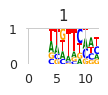

In [14]:
mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=5, n_cols=12) # n_cols=len(reduced_groups))


In [15]:
def unfreeze(model, feat_lab=None, position=None):
    # block mononucleotide but free dinucleotide and activities to calibrate themselves during training
    verbose = 1
    for ki in range(2 + 1):
        mask_pos = (ki == position if position is not None else True)
        mask_mono = (feat_lab == 'mono') and mask_pos
        mask_dinuc = (feat_lab == 'dinuc') and mask_pos
        if verbose != 0:
            print("setting grad status of kernel (mono, dinuc) at %i to (%i, %i)" % (ki, mask_mono, mask_dinuc))
        model.binding_modes.update_grad_mono(ki, mask_mono)
        model.binding_modes.update_grad_di(ki, mask_dinuc)

### Freeze weights and train

In [16]:
# unfreeze(model, None)
# model.binding_modes.update_grad_mono(0, True)
# model.binding_modes.update_grad_di(0, True)

In [17]:
cd ~/workspace/theislab/mubind/notebooks/scatac

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/notebooks/scatac


In [18]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [22]:
atac_path = '../../annotations/scatac/pancreas_multiome_2022_processed_sample_c16918_p50000.h5ad'
os.path.exists(atac_path)

True

In [21]:
!ls -ltrh ../../annotations/scatac/

total 2.9G
-rwxrwxrwx 1 rio rio 2.3G Jan 23 23:02 pancreas_multiome_2022_processed.h5ad
-rwxrwxrwx 1 rio rio 381K Jan 24 19:01 pancreas_multiome_2022_processed_sample_100.h5ad
-rwxrwxrwx 1 rio rio 2.4M Jan 24 19:01 pancreas_multiome_2022_processed_sample_1000.h5ad
-rwxrwxrwx 1 rio rio 1.2M Jan 24 19:01 pancreas_multiome_2022_processed_sample_500.h5ad
-rwxrwxrwx 1 rio rio  50M Jan 25 10:54 pancreas_multiome_2022_processed_sample_10000.h5ad
-rwxrwxrwx 1 rio rio 122M Feb  3 09:15 pancreas_multiome_2022_processed_sample_c16918_p20000.h5ad
-rwxrwxrwx 1 rio rio 170M Feb  3 09:15 pancreas_multiome_2022_processed_sample_c16918_p30000.h5ad
-rwxrwxrwx 1 rio rio 325M Feb  3 09:15 pancreas_multiome_2022_processed_sample_c16918_p50000.h5ad


In [23]:
import scanpy as sc
adata = sc.read_h5ad(atac_path)

In [24]:
adata.X.sum()

95155990.0

In [25]:
adata.shape

(16918, 50000)

In [297]:
adata = adata[:,adata.var.modality == 'ATAC'].copy()

n_sample_cells = 5000
n_sample_peaks = 5000
obs_sample = pd.Series(adata.obs_names).sample(n_sample_cells)
var_sample = pd.Series(adata.var_names).sample(n_sample_peaks)

ad = adata[adata.obs_names.isin(obs_sample),adata.var_names.isin(var_sample)]
ad.shape

(5000, 5000)

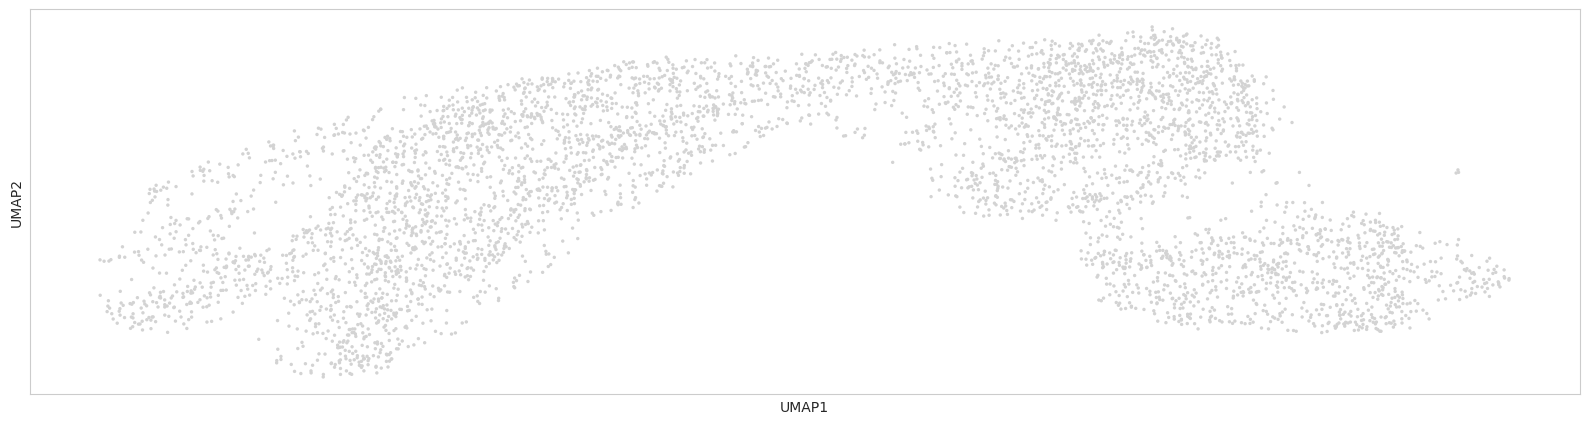

In [298]:
sc.pl.umap(ad)

In [299]:
ad.var

,modality
1-4491745-4492636,ATAC
1-5257825-5258758,ATAC
1-6970577-6971506,ATAC
1-7144145-7145043,ATAC
1-8563994-8564971,ATAC
...,...
X-166533240-166534148,ATAC
X-166626750-166627646,ATAC
X-168672149-168672904,ATAC
Y-90725776-90726677,ATAC


In [300]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

In [301]:
extend = 50

ad.var['chr'].value_counts()

chr2     408
chr1     348
chr5     328
chr4     326
chr11    311
chr8     284
chr9     276
chr10    272
chr6     268
chr7     253
chr3     251
chr13    250
chr14    219
chr12    218
chr15    195
chr17    194
chr18    186
chr16    153
chr19    144
chrX     114
chrY       2
Name: chr, dtype: int64

In [302]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [303]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmpd3e4y3hc
genome mm10 True
../../annotations/mm10/genome/mm10.fa
True ../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../annotations/mm10/genome/mm10.fa -bed /tmp/tmpd3e4y3hc -fo /tmp/tmpk76u5mas


5000

In [304]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [305]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [306]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [307]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(5000, 5001)

In [308]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [309]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [310]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [311]:
next_data_sel

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,var
seq,,,,,,,,,,,,,,,,,,,,,
CCCGCCCAAGCCCGTCCACAGATCAAACGTGGCGCCCCGCGCGCTAATAGGGTCTTTCAAAAGTATTTACGCAACCGATCCTGCCCGCGTTTCCGGCCGC,1.0,2.0,1.0,6.0,0.0,3.0,5.0,3.0,4.0,3.0,...,1.0,3.0,4.0,1.0,1.0,1.0,3.0,0.0,1.0,5.620079
CGCCCGTCAGCCCTCGGGACCCCCTCCGCCCCGCCTTCAGCACCCGGCTGGTGGAAGCCACAAACTCCTTTCCCTCAGCCCCGCCTGCCTCCTCCGTCCC,0.0,3.0,1.0,1.0,1.0,3.0,0.0,4.0,5.0,1.0,...,1.0,3.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,2.861417
CTCGCGAAAAGTTCTGCCGGAGCTCCGCCCCCTCAGCGCCACAGCGGAGCACCAGAGCCTCGCATCACCCACAAAGTCCCGCCTACACAGCAAAGACCCC,1.0,2.0,3.0,1.0,0.0,3.0,1.0,4.0,4.0,0.0,...,3.0,4.0,0.0,2.0,2.0,0.0,2.0,4.0,0.0,2.180420
TCACTCCTCCTCTCCTCCCTTCCGCCCCCACCCCGCCCTCCCGCCAGCACCGCCGCGGGTCACCTGACCCAAGGCCCGGGACGGTTCCGGGTAATGGCCG,3.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,...,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.074274
GGGGCGGGAGCGAAGGGGAGAAAAAAAAAAACTGCCCTGGCGCCCCGCCTCCAGGCGCACAAGCCAGTCAGGACGCATGCGCAGTGGGTGAGGGGCGGGG,0.0,1.0,6.0,6.0,0.0,3.0,4.0,5.0,2.0,2.0,...,2.0,5.0,1.0,0.0,2.0,0.0,2.0,1.0,1.0,2.033710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACATTGACATAATAAATGAATTGGAAAACCCCATTGCTACTTAGCAACCAAAAATGCTCAGCATGGAGATGGCTCCTTCTCCAGCTGTGTGGAGATACCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003588
CTCACATCTATTTCTAATGGGATCTGATGCCCTCTTCTGGTTAGTTGACACAAAACTAGCAAGCACAACTAACCCCTTGTCAACTTAACCCACATCTATA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003389
TCTATTTTCTCTAGGCAGCCTTTCATCTGTCCGTGTGTGTGTGTGTGTGTGCATTTCGCTAAACAGTTTCACTAGTTACTCATTAGTGGTTTCTAAAATA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003190


In [312]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [313]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(5000, 5000)

In [314]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(25000000, 3)
5000
0      5000
137    5000
127    5000
128    5000
129    5000
       ... 
69     5000
70     5000
71     5000
72     5000
199    5000
Name: batch, Length: 200, dtype: int64


,0,1,batch
seq,,,
CCCGCCCAAGCCCGTCCACAGATCAAACGTGGCGCCCCGCGCGCTAATAGGGTCTTTCAAAAGTATTTACGCAACCGATCCTGCCCGCGTTTCCGGCCGC,1.0,1.0,0
CGCCCGTCAGCCCTCGGGACCCCCTCCGCCCCGCCTTCAGCACCCGGCTGGTGGAAGCCACAAACTCCTTTCCCTCAGCCCCGCCTGCCTCCTCCGTCCC,1.0,0.0,0
CTCGCGAAAAGTTCTGCCGGAGCTCCGCCCCCTCAGCGCCACAGCGGAGCACCAGAGCCTCGCATCACCCACAAAGTCCCGCCTACACAGCAAAGACCCC,1.0,1.0,0
TCACTCCTCCTCTCCTCCCTTCCGCCCCCACCCCGCCCTCCCGCCAGCACCGCCGCGGGTCACCTGACCCAAGGCCCGGGACGGTTCCGGGTAATGGCCG,1.0,3.0,0
GGGGCGGGAGCGAAGGGGAGAAAAAAAAAAACTGCCCTGGCGCCCCGCCTCCAGGCGCACAAGCCAGTCAGGACGCATGCGCAGTGGGTGAGGGGCGGGG,1.0,0.0,0


### This is the relatedness graph and used for dynamics filters learning

In [315]:
# sum(adata.obs_names.isin(df.index)

In [316]:
rel = ad[:,~zero_counts].uns['neighbors']['connectivities'].A
# rel[:n_cells,:n_cells].sum()
rel.shape
rel.sum()

12600.648

In [317]:
# df2 = []
# for i in df.columns:
#     df3 = df[[i]].copy()
#     df3 = df3.head(100)
#     df3.columns = [0]
#     df3[1] = 1 # need a minimal non-zero count
#     df3['batch'] = i
#     df2.append(df3)
# df2 = pd.concat(df2)
# # df2['is_count_data'] = True
# dataset = mb.datasets.SelexDataset(df2, n_rounds=2, labels=[0, 1], enr_series=False)
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

1

In [318]:
n_batch = len(set(dataset.batch))
n_batch

1

In [319]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [320]:
# log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, n_batch).to(device)
# log_etas

In [321]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [322]:
n_kernels = len(reduced_groups)
# n_kernels = 8

In [323]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")
ad
criterion = mb.tl.PoissonLoss()

w = [r.shape[1] for r in reduced_groups]
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=False,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None).cuda()

# initialize the reduce kernels
for i, mono_best in enumerate(reduced_groups):
    if mono_best.shape[-1] == 0:
        continue
    # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
    new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
    model.binding_modes.conv_mono[i + 1].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
# move the model a final time to the GPU
model = model.to(device)


In [324]:
model

Multibind(
  (padding): ConstantPad2d(padding=(19, 19, 0, 0), value=0.25)
  (binding_modes): BindingModesSimple(
    (conv_mono): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
      (3): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
      (4): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
      (5): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
      (6): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
      (7): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
      (8): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
    )
    (conv_di): ModuleList(
      (0): None
    )
  )
  (activities): ActivitiesLayer(
    (log_activities): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 1x5000 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTen

True
12


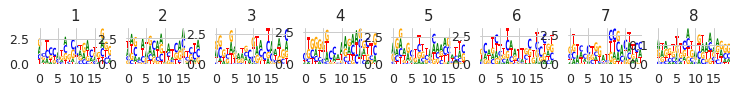

In [325]:
mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=5, n_cols=12) # n_cols=len(reduced_groups))


In [326]:
mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})
# mb.pl.conv(model, n_cols=2)


In [327]:
import torch.nn as tnn
# # Init
# def triu_init(m):
#     with torch.no_grad():
#         m.weight.copy_(torch.triu(m.weight))
#
# # Zero out gradients
# def get_zero_grad_hook(mask):
#     def hook(grad):
#         return grad * mask
#
#     return hook
#
# mask = torch.tril(torch.ones_like(model.selex_module.log_dynamic), -1)
# print(mask.device)
# print(model.selex_module.log_dynamic)
#
# model.selex_module.log_dynamic.register_hook(get_zero_grad_hook(mask))


# here we set up the relationships between cells using the knn graph, for graph-based learning of activities
# model.selex_module.connectivities = torch.tensor(rel).cuda()

model.selex_module.conn_sparse = torch.tensor(ad[:, ~zero_counts].uns['neighbors']['connectivities'].A).to_sparse().requires_grad_(True).cuda()
model.selex_module.log_dynamic = tnn.Parameter(torch.rand(model.selex_module.conn_sparse.indices().shape[1])) # .cuda()
model = model.cuda()
model.selex_module.log_dynamic.shape

torch.Size([35518])

In [328]:
# print(model.selex_module.log_dynamic)
# print(torch.exp(model.selex_module.log_dynamic))

In [ ]:
model, best_loss = model.optimize_iterative(train, n_epochs=[100] + [200] * (n_kernels + 1), show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                            opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                            exp_max=8,
                                            early_stopping=50, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)
setting grad status of kernel (mono, dinuc) at 6 to (0, 0)
setting grad status of kernel (mono, dinuc) at 7 to (0, 0)
setting grad status of kernel (mono, dinuc) at 8 to (0, 0)
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 100 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch: 11, Loss: 0.590967, R2: 0.30,  best epoch: 9,  secs per epoch: 9.470 s,  secs epoch*1k trials: 1.894s
Epoch: 21, Loss: 0.589734, R2: 0.31,  best epoch: 18,  secs per epoch: 9.241 s,  secs epoch*1k trials: 1.848s
Epoch: 31, Loss: 0.589389, R2:

In [ ]:
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)


In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
# mb.pl.conv(model, n_cols=2, show=True)
# plt.show()


In [ ]:
tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

# connectivities
C = model.selex_module.conn_sparse
a_ind = C.indices()

log_dynamic = model.selex_module.log_dynamic
D = model.selex_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
D = D_tril + t(D_triu, 0, 1)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
D

In [ ]:
import seaborn as sns
mb.pl.set_rcParams({'figure.figsize': [3, 3]})
sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [ ]:
torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)


In [ ]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

In [ ]:
ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dynamic_score)
plt.xlabel('dynamic score (normalized)')


In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [ ]:
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

In [ ]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1')

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=5, n_cols=12) # n_cols=len(reduced_groups))


In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)
